<a href="https://colab.research.google.com/github/willyptrain/cs4774-mask-detection/blob/new_master/py_notebooks/yolo_and_rcnn_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
__author__ = 'wcp7cp'

# General imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import os
import sys
import pandas as pd

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

import scipy.io as sio
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import numpy as np
import cv2
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import matplotlib.pyplot as plt
import matplotlib

from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import os
import sys
import pandas as pd

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

import scipy.io as sio
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import numpy as np
import cv2
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import matplotlib.pyplot as plt
import matplotlib

class YoloModel:
    def __init__(self, weights, config, coco):
        self.weights = weights
        self.config = config
        self.coco = coco
        self.output_layers = []
        self.net = self.load_model()
        self.classes = open(self.coco).read().split("\n")
    
    def load_model(self):
        net = cv2.dnn.readNetFromDarknet(self.config, self.weights)
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        layer_names = net.getLayerNames()
        self.output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
        return net
    
    def transform_bounding_box(self,box, shape=(416,416)):
        
        box = box * np.array([shape[1], shape[0], shape[1], shape[0]]) #width, height, width, height => scale the image
        box = [int(box[0] - (box[2] / 2)), int(box[1] - (box[3] / 2)), int(box[2]), int(box[3])] #xmin, ymin, width, height
        return box

    def get_label_score(self,scores, label="person"):
        label_index = self.classes.index(label)
        return scores[label_index]

    def plot_boxes(self, img, boxes):
        fig,ax = plt.subplots(1) 
        ax.imshow(img)#.permute(1, 2, 0))
        for box in boxes:
            xmin = box[0]
            ymin = box[1]
            w = box[2] 
            h = box[3]
            color = (0,1,0,0.99) 
            facecolor = (0,1,0,0.2) 
            rect = matplotlib.patches.Rectangle((xmin,ymin),xmin+w,ymin+h,edgecolor=color,facecolor=facecolor)
            ax.add_patch(rect)
        plt.show()

    def predict(self, img, label="person", threshold=0.70, nms_threshold=0.4,plot=True):
        img = cv2.resize(img, (416,416))
        blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=True)
        self.net.setInput(blob)


        feed_forward_output = self.net.forward(self.output_layers)
        classes = open(self.coco).read().split("\n")
        person_index = self.classes.index("person")

        boxes = []
        scores = []
        
        for output in feed_forward_output:
            for detection in output: #shape of detection is (85,1) => index 0-4 for bounding box, index 5-85 for scores for each class in coco.names
                label_score = self.get_label_score(detection[5:],label)
                box = detection[0:4] #center X, center Y, width, height
                
                box = self.transform_bounding_box(box, (416,416))
                if(label_score > threshold):
                    boxes.append([box[0],box[1],box[2],box[3]]) #read somewhere that NMSBoxes only takes lists, not np arrays
                    scores.append(float(label_score))

        
        non_overlap_indices = cv2.dnn.NMSBoxes(boxes, scores, threshold, nms_threshold) 
        if(type(non_overlap_indices) is not tuple):
            top_boxes = [boxes[int(i)] for i in non_overlap_indices.flatten()]
            if(plot):
                self.plot_boxes(img,top_boxes)

            return {"boxes": top_boxes, "label_count":len(top_boxes) } 
        else:
            return {"boxes": [], "label_count":0} 




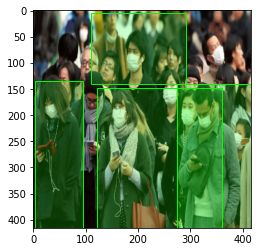

4 persons detected


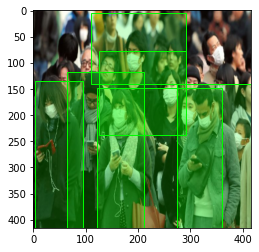

6 persons detected


In [14]:
yolo_weights = "/content/drive/My Drive/yolov3.weights"
yolo_cfg = "/content/drive/My Drive/yolov3.cfg"
yolo_coco = 'drive/My Drive/coco.names'
yolo = YoloModel(yolo_weights, yolo_cfg, yolo_coco)
test = cv2.cvtColor(cv2.imread("drive/My Drive/sample_img.jpg"), cv2.COLOR_BGR2RGB)
print(yolo.predict(test,nms_threshold=0.01)["label_count"], "persons detected")
print(yolo.predict(test,nms_threshold=0.99)["label_count"], "persons detected")


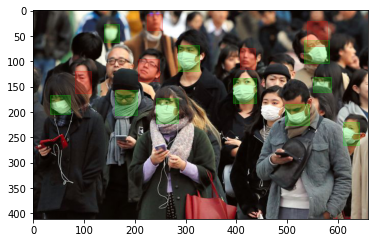

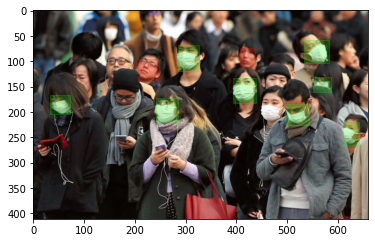

{'boxes': [[205.550537109375,
   95.44976043701172,
   247.1669158935547,
   138.03099060058594],
  [406.2629699707031, 74.122314453125, 437.6439514160156, 114.9696273803711],
  [241.38009643554688,
   172.93568420410156,
   285.4582214355469,
   222.53314208984375],
  [534.1365356445312, 58.49480438232422, 581.69970703125, 103.43411254882812],
  [496.1112976074219,
   183.53701782226562,
   542.9993896484375,
   226.37867736816406],
  [283.97210693359375,
   67.41197204589844,
   326.7740783691406,
   119.41100311279297],
  [394.0402526855469,
   133.09165954589844,
   438.3813171386719,
   182.57681274414062],
  [32.94189453125, 165.90216064453125, 72.62934875488281, 203.06117248535156],
  [610.044921875, 219.87686157226562, 641.1824340820312, 265.2257995605469],
  [550.6170654296875,
   130.40367126464844,
   587.1295776367188,
   160.1292724609375]],
 'label_frequencies': {'background': 0,
  'mask_weared_incorrect': 0,
  'with_mask': 8,
  'without_mask': 2},
 'labels': [1, 1, 3, 3,

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import os
import sys
import pandas as pd


from keras.wrappers.scikit_learn import KerasClassifier
from collections import Counter
import scipy.io as sio
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import numpy as np
import cv2
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms, datasets, models


class FasterRCNN:
    def __init__(self, weight_zip):
        self.weight_zip = weight_zip
        # self.net = 
        # self.classes = 
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
        self.num_classes = 4
        self.model = self.load_model()
    
    def load_model(self, eval=True):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #loads the Faster R-CNN model trained on the COCO dataset
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes) #number of classes = 3 : with_mask, without_mask, mask_not_worn_corrected
        model.load_state_dict(torch.load(self.weight_zip,map_location=self.device))
        if torch.cuda.is_available():
            model.cuda()
        if(eval):
            model.eval()
        return model

    def transform(self, data):
        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
        ]) 
        return tensor_transform(data)

    
    
    def plot_boxes(self, img, annotation, plot_save_to=None):
        fig,ax = plt.subplots(1) 
        # img = img_tensor.cpu().data

        label_mappings = {"with_mask": 3, "mask_weared_incorrect": 2, "without_mask":1} #0 for background class, not used 
        label_tags = ["background","without_mask", "mask_weared_incorrect", "with_mask"]
    
        ax.imshow(img)
        
        for i, box in enumerate(annotation["boxes"]):
            xmin, ymin, xmax, ymax = box
            # print(float(annotation["scores"][i]), label_tags[annotation["labels"][i]])       
            color = (0,1,0,0.2) if (annotation["labels"][i] == 3) else (1,0,0,0.2)
            rect = matplotlib.patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,edgecolor=color,facecolor=color)
            ax.add_patch(rect)
        
        if(plot_save_to):
            plt.savefig(plot_save_to)

        
        plt.show()


    def predict(self, img, threshold=0.75, plot=True, plot_save_to=None):
        img_tensor = self.transform(img)
        img_tensor = img_tensor.to(self.device)
        annotation = self.model([img_tensor])
        boxes = [[box[0].item(),box[1].item(),box[2].item(),box[3].item()] for box in annotation[0]["boxes"]]
        scores = [float(score) for score in annotation[0]["scores"]]
        labels = [int(label) for label in annotation[0]["labels"]]
        non_overlap_indices = cv2.dnn.NMSBoxes(boxes, scores, threshold, 0.4) 
        if(type(non_overlap_indices) is not tuple):
            top_boxes = [boxes[int(i)] for i in non_overlap_indices.flatten()]
            top_scores = [scores[int(i)] for i in non_overlap_indices.flatten()]
            top_labels = [labels[int(i)] for i in non_overlap_indices.flatten()]
            # print("Detected:")
            label_mappings = {3:"with_mask", 2:"mask_weared_incorrect", 1:"without_mask", 0:"background"} #0 for background class, not used 
            string_labels = map(label_mappings.get, top_labels)
            label_frequencies = {"with_mask":0, "mask_weared_incorrect":0,"without_mask":0,"background":0}#Counter(string_labels)
            
            for label in string_labels:
                label_frequencies[label] = label_frequencies.get(label, 0) + 1
            
            # for tup in label_frequencies.most_common():
                # print("\t", tup[0], tup[1])
            top_annotation = {
                "boxes":top_boxes,
                "labels":top_labels,
                "scores":top_scores,
                "label_frequencies":label_frequencies
            }
            if(plot):
                self.plot_boxes(img,top_annotation, plot_save_to)
        else:
            top_annotation = {
                "boxes":[],
                "labels":[],
                "scores":[],
                "label_frequencies":{"with_mask":0, "mask_weared_incorrect":0,"without_mask":0,"background":0}#Counter(string_labels)
            }

        return top_annotation


rcnn = FasterRCNN("drive/My Drive/updated_rcnn.zip")
test = Image.open("drive/My Drive/sample_img.jpg").convert("RGB")
rcnn.predict(test,threshold=0.01, plot=True)
rcnn.predict(test,threshold=0.99, plot=True)


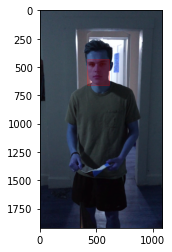

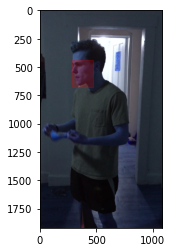

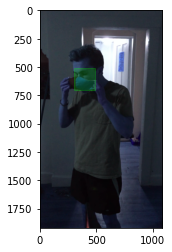

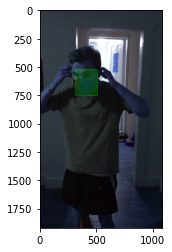

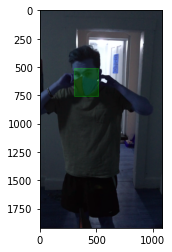

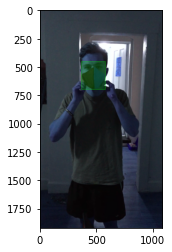

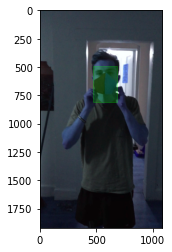

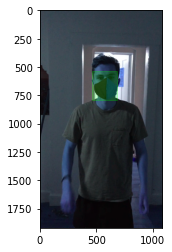

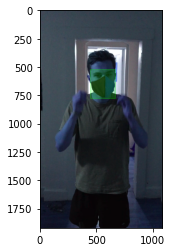

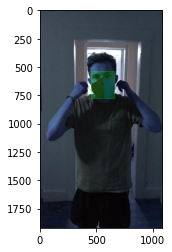

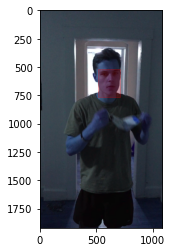

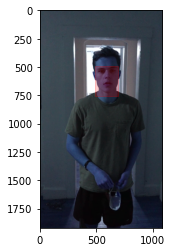

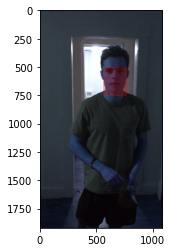

In [16]:

frame_count = 0
frames = []
capture = cv2.VideoCapture('drive/My Drive/IMG_0157.mp4')  
step = 20  
while True:
    ret, frame = capture.read()
    if not ret:
        break        
    frame_count += 1
    if(frame_count % step == 0):
      frames.append(frame)

for frame in frames:
  rcnn.predict(frame)



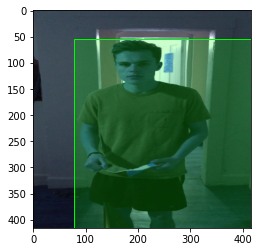

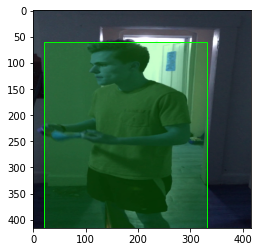

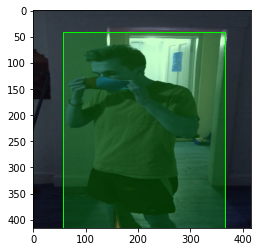

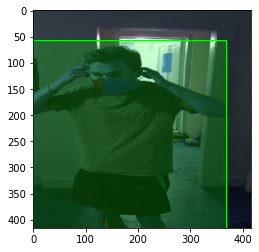

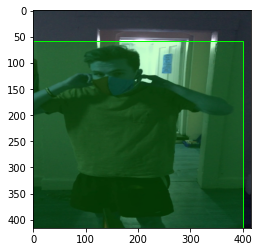

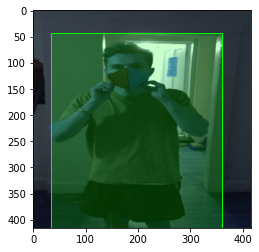

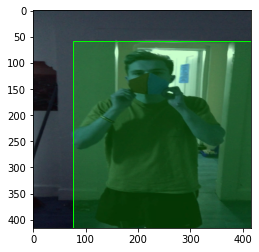

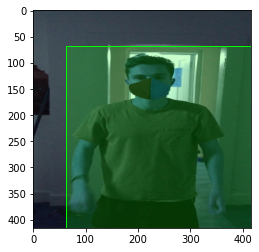

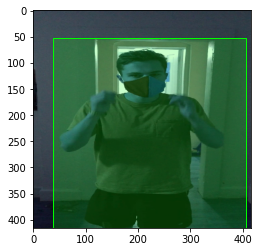

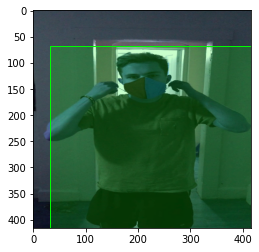

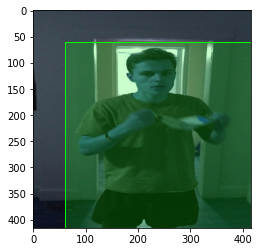

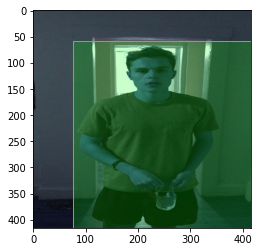

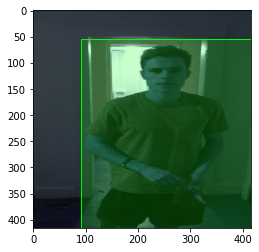

In [17]:

frame_count = 0
frames = []
capture = cv2.VideoCapture('drive/My Drive/IMG_0157.mp4')  
step = 20  
while True:
    ret, frame = capture.read()
    if not ret:
        break        
    frame_count += 1
    if(frame_count % step == 0):
      frames.append(frame)

for frame in frames:
  yolo.predict(frame)